## Run the following models:

### Linear Regression models. [Y~.]
A Dummy for Year factor/Year Built, controls for building class/facility type/statefactor and dummies for monthly temperatures

### Diff in Diff model.

•	State Differences: Could provide answers on how EUIs are impacted in different states, due to different policies.

•	Year Built: Could provide answers about the need for retrofitting or demolishing. 
Process: take State0/Year0 as base case and compare the linear regression models across.

### Regression Trees
Turn it into a classification problem, by setting an acceptable rate of eui (looking at current policy). Fit a random forest algorithm to obtain coefficients that determine if the building energy is too high.

### RNN:
Fit a supervised learning model preferably a RNN to compare the econometric model with ML model and observe any deviances.

## formulating transformations

[Relating residential and commercial sector electricity loads to climate—evaluating state level sensitivities and vulnerabilities by David J Sailor](https://www.sciencedirect.com/science/article/pii/S0360544201000238?pes=vor)

$$E = \beta_0 + \beta_1 CDD + \beta_2 HDD + \beta_3 U + \beta_4 ELD$$

$$E = 28.36 + 0.0138 CDD + 0.0087 HDD + -0.0175 U + Z_t$$
$E$ is energy use, 
$CDD$ is cooling days
$HDD$ is heating days
$U$ is max wind speed



### population weighted monthly average temp

$$T = CDD- HDD + 65 * D$$

In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
# loading in DATA
train_df = pd.read_csv('data/kaggle/train.csv')
# train_df.

In [5]:
# windDf['max_wind_speed'].value_counts()

In [6]:
windsensordf = train_df[train_df.max_wind_speed.isna()==False]
windDf = windsensordf[['direction_max_wind_speed','direction_peak_wind_speed','max_wind_speed']]

windDf.apply(lambda x: x.value_counts()).T.stack()

direction_max_wind_speed   1.0      27724.0
                           270.0       12.0
                           280.0       22.0
                           300.0        7.0
                           310.0     2439.0
                           320.0       49.0
                           330.0     3011.0
                           340.0        1.0
                           350.0      485.0
                           360.0      925.0
direction_peak_wind_speed  1.0      27699.0
                           270.0       12.0
                           310.0     1260.0
                           320.0      491.0
                           330.0      104.0
                           340.0     2931.0
                           350.0        3.0
                           360.0     1446.0
max_wind_speed             1.0      27724.0
                           10.7         4.0
                           12.5        12.0
                           13.0      1260.0
                           13.4 

 going to remove the dummy values 1 from the wind data

In [7]:
windsensordf = windsensordf.drop('direction_peak_wind_speed',axis=1)

In [8]:
reg_dfX = windsensordf[['cooling_degree_days','heating_degree_days','direction_max_wind_speed','max_wind_speed','site_eui']]#.fillna(0)
#reg_dfX = reg_dfX[reg_dfX.direction_peak_wind_speed.isna()==False]
# i dropped the peak wind speed as it was 0.96 coreelated with max wind speed, and as per definition it only lasts for a few seconds
# hence max speed is more necessary.
reg_dfy = reg_dfX.site_eui
reg_dfX = reg_dfX.drop(['site_eui'],axis=1)


In [9]:
len(windsensordf)

34675

NA values test

In [10]:
total = len(reg_dfX['heating_degree_days'])
naCount = sum(reg_dfX['max_wind_speed'].isna())
naCount/total

0.0

## Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(y = reg_dfy,X = reg_dfX)
r_sq = model.score(y = reg_dfy,X = reg_dfX)

In [12]:
reg_dfX.isna()

,cooling_degree_days,heating_degree_days,direction_max_wind_speed,max_wind_speed
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
73151,False,False,False,False
73152,False,False,False,False
73153,False,False,False,False
73154,False,False,False,False


In [13]:
r_sq

0.009176704913901101

In [14]:
model.intercept_

27.267357922448994

In [15]:
import math
import statistics
preds = model.predict(X = reg_dfX)
rmse = math.sqrt(abs(statistics.mean(reg_dfy - preds)))
rmse

1.2691914749669936e-07

Text(0.5, 1.0, 'Residual plot')

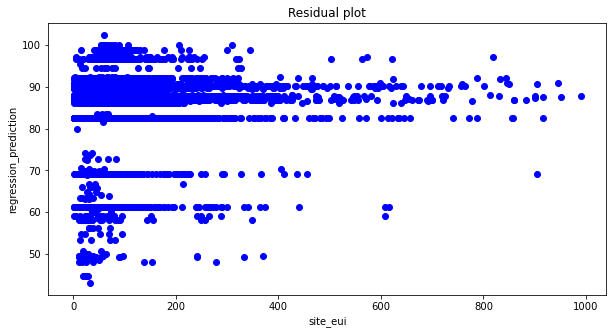

In [16]:
#temperature_dat = train_df.loc[:,'january_min_temp':'december_max_temp']
#test = temperature_dat.filter(like='avg')
#test.head()
plt.figure(figsize=(10,5))
#plt.plot(preds.transpose())
plt.plot(reg_dfy,preds.transpose(),'bo')
plt.xlabel('site_eui')
plt.ylabel('regression_prediction')
plt.title('Residual plot')
#plt.legend(test.columns,loc='right')

In [17]:
model.coef_

array([ 0.01117393,  0.01029013, -0.01622041,  0.11947126])

$$E = 60.85 + -0.004 CDD + 0.008 HDD + -0.019 \gamma + 0.105 U + Z_t$$

(array([8.0000e+00, 4.6000e+01, 9.0000e+00, 6.2000e+01, 6.0600e+02,
        6.3200e+02, 9.0000e+00, 6.5220e+03, 2.6349e+04, 4.3200e+02]),
 array([3.76497611, 3.85130115, 3.9376262 , 4.02395124, 4.11027628,
        4.19660133, 4.28292637, 4.36925142, 4.45557646, 4.54190151,
        4.62822655]),
 <BarContainer object of 10 artists>)

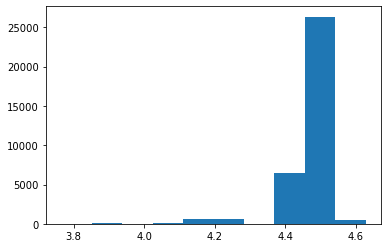

In [18]:
plt.hist(np.log(preds))

## Random forest 

In [19]:
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=80, max_features='auto')
# trainX = windsensordf.iloc[:-1,:]
# trainy = windsensordf['site_eui']
# rf.fit(trainX, trainy)
# print("Training done using Random Forest")

# ranking = np.argsort(-rf.feature_importances_)
# f, ax = plt.subplots(figsize=(11,9))
# sns.barplot(x=rf.feature_importances_[ranking], y=trainX.columns.values[ranking], orient='h')
# ax.set_xlabel("Feature Importance")
# plt.tight_layout()
# plt.show()

In [20]:
# rf.score(y = reg_dfy,X = reg_dfX)

Running the model on annual total days data

In [21]:
pd.DataFrame(train_df.columns)

,0
0,Year_Factor
1,State_Factor
2,building_class
3,facility_type
4,floor_area
...,...
59,direction_peak_wind_speed
60,max_wind_speed
61,days_with_fog
62,site_eui


<AxesSubplot:>

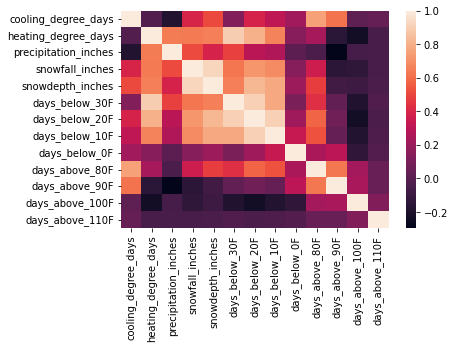

In [29]:
regX = train_df.iloc[:,44:58].drop('avg_temp',axis=1)
# regX.to_pickle('data/datasets/auxregX.pkl')
sns.heatmap(regX.corr('spearman'))

In [31]:
regY = train_df[['avg_temp']]
# regY.to_pickle('data/datasets/auxyreg.pkl')
daymodel = LinearRegression().fit(y = regY,X = regX)
dayrsq = daymodel.score(y = regY,X = regX)

In [24]:
dayrsq

0.9996126438190437

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

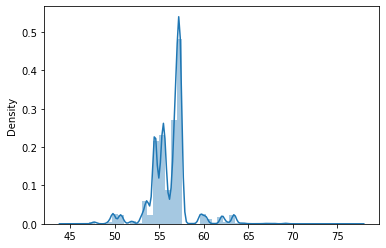

In [25]:
sns.distplot(regY)

In [26]:
daymodel.coef_.round(3)

array([[ 0.003, -0.003, -0.005,  0.002,  0.   , -0.001, -0.007, -0.005,
         0.012, -0.001,  0.   ,  0.004, -0.027]])

Looking at the results from the regression above, i am going to remove the avg temp and replace it with the auxillary regression equation. to remove multicolinearity from the model.

$$\gamma = \alpha + 0.003CDD_i - 0.003HDD_i -0.005P_i +0.002S_i + $$

In [27]:
regX.columns


Index(['cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
       'snowfall_inches', 'snowdepth_inches', 'days_below_30F',
       'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F',
       'days_above_90F', 'days_above_100F', 'days_above_110F'],
      dtype='object')

In [173]:
train_df.groupby('Year_Factor').snowdepth_inches.mean()

Year_Factor
1    344.789325
2      9.330316
3     51.440022
4    288.925769
5    302.115305
6     82.136220
Name: snowdepth_inches, dtype: float64

In [174]:
train_df.groupby('State_Factor').snowdepth_inches.mean()

State_Factor
State_1       1.300997
State_10     47.400000
State_11      2.439333
State_2      33.295627
State_4     237.570465
State_6     213.452085
State_8     116.234531
Name: snowdepth_inches, dtype: float64

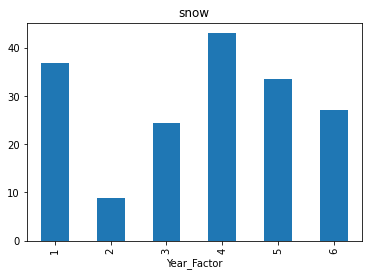

In [185]:
train_df.groupby('Year_Factor').snowfall_inches.mean().plot(kind='bar',title='snow')

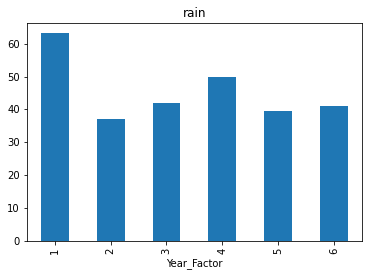

In [184]:
train_df.groupby('Year_Factor').precipitation_inches.mean().plot(kind='bar',title='rain')

Year_Factor
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
Name: precipitation_inches, dtype: object

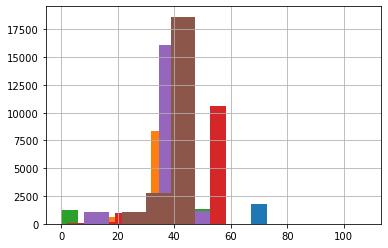

In [188]:
train_df.groupby('Year_Factor').precipitation_inches.hist()

In [189]:
train_df[train_df.Year_Factor==1]

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.500000,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.500000,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16530,1,State_6,Residential,Multifamily_Uncategorized,371347.0,1931.0,14.0,3.4,6,29.677419,...,84,16,1,0,1.0,1.0,1.0,12.0,111.330128,16530
16531,1,State_6,Commercial,Education_College_or_university,131979.0,1956.0,NaN,3.4,6,29.677419,...,84,16,1,0,1.0,1.0,1.0,12.0,131.941209,16531
16532,1,State_6,Commercial,Education_College_or_university,183559.0,1848.0,NaN,3.4,6,29.677419,...,84,16,1,0,1.0,1.0,1.0,12.0,134.735252,16532
16533,1,State_6,Commercial,Nursing_Home,59479.0,1968.0,15.0,3.4,6,29.677419,...,84,16,1,0,1.0,1.0,1.0,12.0,187.599239,16533


In [199]:
train_df.Year_Factor.value_counts().diff(-1)

6    4141.0
5    5362.0
4    2067.0
3    1821.0
2    6941.0
1       NaN
Name: Year_Factor, dtype: float64

can i weight my coefficients according to the data i have, should i divide every explanatory variable by its year total observations?
can i run a differences in differences regression with unbalanced 